In [1]:
import scipy.integrate as integrate
from numpy import sqrt, exp, pi, log
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.linalg.lapack import dgtsv
plt.style.use("dark_background")

In [2]:
A_b = 0.0001
B_b = 0.00026
A = A_b
B = B_b
o = 1.065
def mort(x):
    return A + B*pow(o,x)
def p(t,x):
    F = B*pow(o,x)/log(o)
    return exp(-(A*t + F*(pow(o,t)-1)))

In [3]:
k = 0.25 #time
h = 2.5 #space

N = 40
I = 100

mu = 0.5 ## From Low to high
nu = 0.5 ## From High to Low

fot = [mu,nu]

r = 0.03

sigma = [0.15, 0.25]

p12 = exp(-mu*h)
p21 = exp(-nu*h)
## Initial Probabilities
pi = [p21 / (p12 + p21), p12 / (p12 + p21)]

t = 0
T = N*k

## Guarantee Conditions
GMMB = 100
fee = 0.02
kappa = 0.05
GMDB = 100
F_max = h*I


In [4]:
def f(u,timestep,age):
    return GMDB*exp(-r*(u+timestep*k))*p(u,age+timestep*k)*mort(age+timestep*k+u)

def db_if_crash(timestep,age):
    return GMMB*exp(-r*(T-timestep*k))*p(T-timestep*k,age+timestep*k)+integrate.quad(lambda x : f(x,timestep,age),0,T-timestep*k)[0]

In [5]:
def crank(U,j,age,Vj,timestep):
    # Lower Diagonal
    A = [-(2*k*(0.5*pow(sigma[j]*i*h,2))+k*h*(r-fee+kappa)*i*h) for i in range(1,I+1)]
    # Main Diagonal
    B = [(4*pow(h,2)+4*k*(0.5*pow(sigma[j]*i*h,2))-2*pow(h,2)*k*(-mort(age + timestep*k)-r-fot[j])) for i in range(0,I+1)]
    # Upper Diagonal
    C = [(2*k*(0.5*pow(sigma[j]*i*h,2))+k*h*(r-fee+kappa)*i*h) for i in range(0,I)]
    D = [(2*k*(0.5*pow(sigma[j]*i*h,2))+k*h*(r-fee+kappa)*i*h)*U[i+1] + (4*pow(h,2)-4*k*(0.5*pow(sigma[j]*i*h,2))+2*pow(h,2)*k*(-mort(age + timestep*k)-r-fot[j]))*U[i] + (2*k*(0.5*pow(sigma[j]*i*h,2))-k*h*(r-fee+kappa)*i*h)*U[i-1] + 4*pow(h,2)*k*(fot[j]*Vj[timestep][i] + mort(age + timestep*k)*max(GMDB,i*h)) for i in range(1,I)]
    ## Boundary conditions on D when x = 0, x_max
    D.insert(0,db_if_crash(timestep,age))
    D.insert(-1,F_max*exp(-kappa*(T-timestep*k)))
    return dgtsv(C,B,A,D)[3] # Next step of function values

In [6]:
def dist(A,B):
    A = np.array(A)
    B = np.array(B)
    diff = A - B
    return sqrt(np.trace(diff.T @ diff))

In [21]:
age = 50
tol = 0.001
converged = False
Vn1 = np.zeros((I+1,N+1)).T
Vn2 = np.zeros((I+1,N+1)).T
DONE = 0
B1 = []
B2 = []
while not converged:
    
    B1 = [GMMB]
    B2 = [GMMB]
    
    ## 1
    U = np.array([max(GMMB, s*h) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN1 = [U]
    for n in range(N):
        X = crank(U,0,age,Vn2,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b1 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X[10:],range(10,I+1))]
        B1.append(np.where(b1)[0][0]*h + 25)
        VCN1.append(new)
        U = new
    D1 = dist(Vn1,np.array(VCN1))
    
    ## 2
    U = np.array([max(GMMB, s*h) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN2 = [U]
    for n in range(N):
        X = crank(U,1,age,Vn1,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b2 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X[10:],range(10,I+1))]
        B2.append(np.where(b2)[0][0]*h + 25)
        VCN2.append(new)
        U = new
    D2 = dist(Vn2,np.array(VCN2))
    
    ## Check if converged
    if max(D1,D2) < tol:
        converged = True
        print(max(D1,D2))
        
    ## Set up next iter if not converged    
    Vn1 = VCN1
    Vn2 = VCN2
    DONE+=1
    if DONE == 100:
        break
B1 = [x for x in reversed(B1)]
B2 = [x for x in reversed(B2)]
DONE

0.0007357529948479616


17

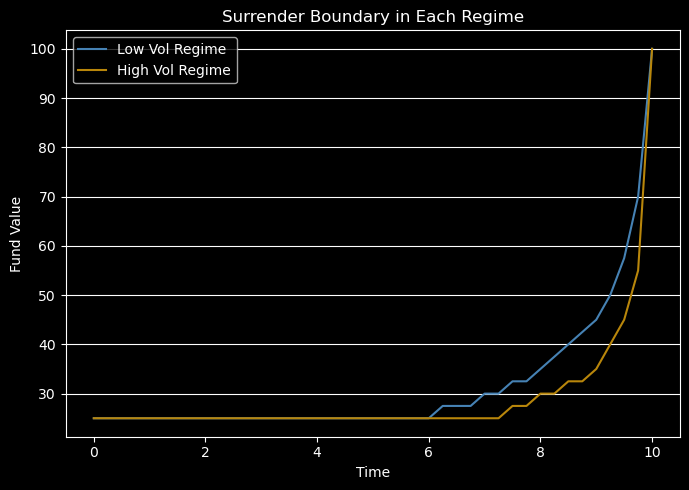

In [22]:
fig, ax1 = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
fg_color = 'white'
bg_color = 'black'

im1 = ax1.plot([t*k for t in range(N+1)],B1,c="steelblue")
im2 = ax1.plot([t*k for t in range(N+1)],B2,c="darkgoldenrod")
# IMSHOW    
# set title plus title color
ax1.set_title('Surrender Boundary in Each Regime', color=fg_color)
ax1.set_xlabel("Time",c="white")
ax1.set_ylabel("Fund Value",c="white")
ax1.legend(["Low Vol Regime","High Vol Regime"])
ax1.grid(axis="y")
ax1.patch.set_facecolor(bg_color)

ax1.axes.tick_params(color=fg_color, labelcolor=fg_color)

for spine in ax1.axes.spines.values():
    spine.set_edgecolor(fg_color)    


fig.patch.set_facecolor(bg_color)    
plt.tight_layout()
plt.show()

In [10]:
#A = A_b * 2
#B = B_b * 2
sigma = [0.35, 0.45]
r = 0.01
#GMDB = 200
#GMMB = 200
age = 55
tol = 0.0001
converged = False
Vn1 = np.zeros((I+1,N+1)).T
Vn2 = np.zeros((I+1,N+1)).T
DONE = 0
B1vU = []
B2vU = []
while not converged:
    
    B1vU = [GMMB]
    B2vU = [GMMB]
    
    ## 1
    U = np.array([max(GMMB, s*h) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN1 = [U]
    for n in range(N):
        X = crank(U,0,age,Vn2,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b1 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X,range(I+1))]
        B1vU.append(np.where(b1)[0][0]*h)
        VCN1.append(new)
        U = new
    D1 = dist(Vn1,np.array(VCN1))
    
    ## 2
    U = np.array([max(GMMB, s*h) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN2 = [U]
    for n in range(N):
        X = crank(U,1,age,Vn1,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b2 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X,range(I+1))]
        B2vU.append(np.where(b2)[0][0]*h)
        VCN2.append(new)
        U = new
    D2 = dist(Vn2,np.array(VCN2))
    
    ## Check if converged
    if max(D1,D2) < tol:
        converged = True
        print(max(D1,D2))
        
    ## Set up next iter if not converged    
    Vn1 = VCN1
    Vn2 = VCN2
    DONE+=1
    if DONE == 100:
        break
B1vU = [x for x in reversed(B1vU)]
B2vU = [x for x in reversed(B2vU)]
DONE

5.9602230145482705e-05


18

In [11]:
#A = A_b * 0.5
#B = B_b * 0.5
sigma = [0.075, 0.125]
r = 0.06
#GMDB = 50
#GMMB = 50
age = 55
tol = 0.0001
converged = False
Vn1 = np.zeros((I+1,N+1)).T
Vn2 = np.zeros((I+1,N+1)).T
DONE = 0
B1vD = []
B2vD = []
while not converged:
    
    B1vD = [GMMB]
    B2vD = [GMMB]
    
    ## 1
    U = np.array([max(GMMB, s*h) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN1 = [U]
    for n in range(N):
        X = crank(U,0,age,Vn2,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b1 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X,range(I+1))]
        B1vD.append(np.where(b1)[0][0]*h)
        VCN1.append(new)
        U = new
    D1 = dist(Vn1,np.array(VCN1))
    
    ## 2
    U = np.array([max(GMMB - s*h,0) for s in range(I+1)])  ## Time to maturity 0 boundary
    VCN2 = [U]
    for n in range(N):
        X = crank(U,1,age,Vn1,n)
        new = [max(x, s*h*exp(-kappa*n*k)) for x,s in zip(X,range(I+1))]
        b2 = [x <= s*h*exp(-kappa*n*k) for x,s in zip(X,range(I+1))]
        B2vD.append(np.where(b2)[0][0]*h)
        VCN2.append(new)
        U = new
    D2 = dist(Vn2,np.array(VCN2))
    
    ## Check if converged
    if max(D1,D2) < tol:
        converged = True
        print(max(D1,D2))
        
    ## Set up next iter if not converged    
    Vn1 = VCN1
    Vn2 = VCN2
    DONE+=1
    if DONE == 100:
        break
B1vD = [x for x in reversed(B1vD)]
B2vD = [x for x in reversed(B2vD)]
DONE

2.209486590637878e-05


19

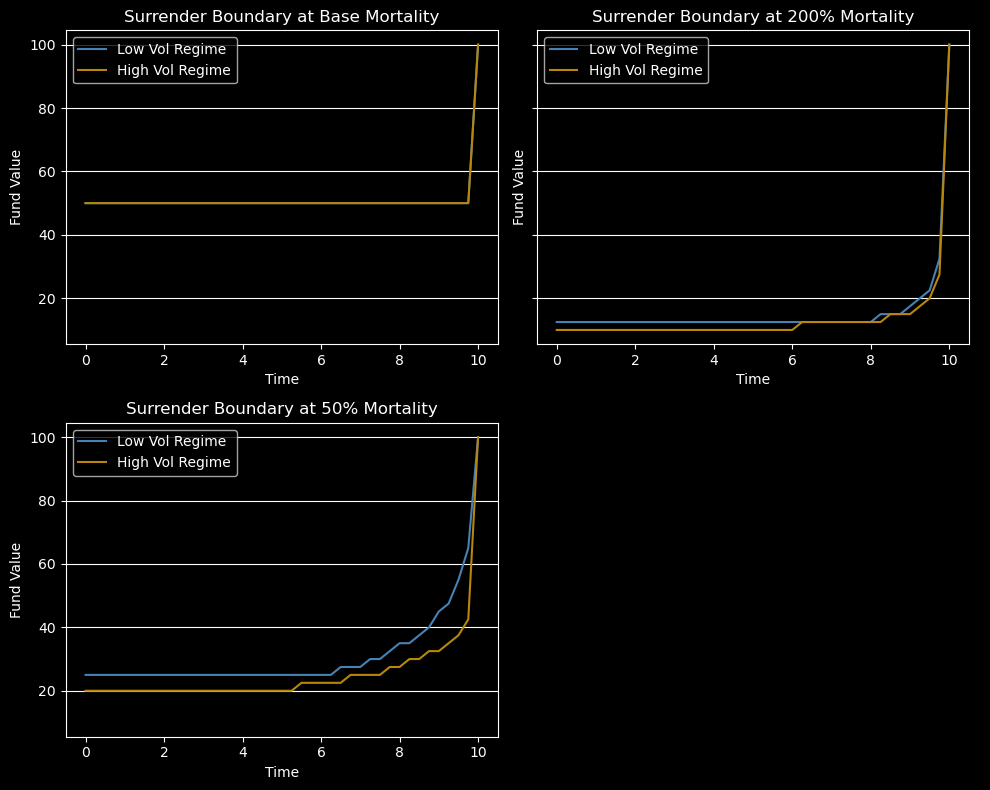

In [12]:
fig, ax1 = plt.subplots(2,2,sharey=True)
fig.set_figheight(8)
fig.set_figwidth(10)
fg_color = "white"

ax1[0][0].plot([t*k for t in range(N+1)],B1, c = "steelblue")
ax1[0][0].plot([t*k for t in range(N+1)],B2, c = "darkgoldenrod")
ax1[0][1].plot([t*k for t in range(N+1)],B1vU, c = "steelblue")
ax1[0][1].plot([t*k for t in range(N+1)],B2vU, c = "darkgoldenrod")
ax1[1][0].plot([t*k for t in range(N+1)],B1vD, c = "steelblue")
ax1[1][0].plot([t*k for t in range(N+1)],B2vD, c = "darkgoldenrod")
# IMSHOW    
# set title plus title color
ax1[0][0].set_title('Surrender Boundary at Base Mortality', color=fg_color)
ax1[0][0].set_xlabel("Time",c="white")
ax1[0][0].set_ylabel("Fund Value",c="white")
ax1[0][0].grid(axis="y")

ax1[0][1].set_title('Surrender Boundary at 200% Mortality', color=fg_color)
ax1[0][1].set_xlabel("Time",c="white")
ax1[0][1].set_ylabel("Fund Value",c="white")
ax1[0][1].grid(axis="y")

ax1[1][0].set_title('Surrender Boundary at 50% Mortality', color=fg_color)
ax1[1][0].set_xlabel("Time",c="white")
ax1[1][0].set_ylabel("Fund Value",c="white")
ax1[1][0].grid(axis="y")

ax1[0][0].legend(["Low Vol Regime","High Vol Regime"])
ax1[0][1].legend(["Low Vol Regime","High Vol Regime"])
ax1[1][0].legend(["Low Vol Regime","High Vol Regime"])

for spine in ax1[1][1].axes.spines.values():
    spine.set_edgecolor("black")
ax1[1][1].axes.tick_params(color="black", labelcolor="black")
ax1[1][1].grid(visible=False)

plt.tight_layout()
plt.show()